In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0117.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0101.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0108.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0110.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0119.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0115.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0116.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0105.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0106.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0121.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0111.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0103.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0120.jpeg
/kaggle/input/covid19-image-dataset/Co

In [3]:
!pip install imutils
import os
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

plt.style.use('ggplot')

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=68c6df474d31f2eb51c4550f8363ba2a0ffce2f64794e75e5a7840b248c702c2
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [4]:
os.listdir("/kaggle/input/covid19-image-dataset/Covid19-dataset/")

['test', 'train']

In [5]:
imagePathsTrain = list(paths.list_images("/kaggle/input/covid19-image-dataset/Covid19-dataset/train"))
trainX = []
trainY = []

for imagePath in imagePathsTrain:

    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    trainX.append(image)
    trainY.append(label)

trainX = np.array(trainX, dtype="float32")
trainY = np.array(trainY)

lb = LabelEncoder()
trainY = lb.fit_transform(trainY)
trainY = to_categorical(trainY)


In [6]:
imagePathsTest = list(paths.list_images("/kaggle/input/covid19-image-dataset/Covid19-dataset/test"))
testX = []
testY = []

for imagePath in imagePathsTest:

    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    testX.append(image)
    testY.append(label)

testX = np.array(testX, dtype="float32")
testY = np.array(testY)

lb = LabelEncoder()
testY = lb.fit_transform(testY)
testY = to_categorical(testY)


In [7]:
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.15, random_state=42, stratify=trainY)


In [8]:
print("SHAPE OF TRAIN FEATURES: "+str(trainX.shape))
print("SHAPE OF TRAIN LABELS: "+str(trainY.shape))
print("SHAPE OF VALIDATION FEATURES: "+str(valX.shape))
print("SHAPE OF VALIDATION LABELS: "+str(valY.shape))
print("SHAPE OF TEST FEATURES: "+str(testX.shape))
print("SHAPE OF TEST LABELS: "+str(testY.shape))

SHAPE OF TRAIN FEATURES: (213, 224, 224, 3)
SHAPE OF TRAIN LABELS: (213, 3)
SHAPE OF VALIDATION FEATURES: (38, 224, 224, 3)
SHAPE OF VALIDATION LABELS: (38, 3)
SHAPE OF TEST FEATURES: (66, 224, 224, 3)
SHAPE OF TEST LABELS: (66, 3)


In [9]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [10]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32


In [11]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = True

opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

2022-03-24 19:18:37.129139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 19:18:37.224241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 19:18:37.225105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 19:18:37.226304: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
HR = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(valX, valY),
    validation_steps=len(valX) // BS,
    epochs=EPOCHS)

2022-03-24 19:19:07.630442: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-03-24 19:19:13.693019: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6/6 [==============================] - 15s 606ms/step - loss: 1.3648 - accuracy: 0.3594 - val_loss: 0.8951 - val_accuracy: 0.5000
Epoch 2/20
6/6 [==============================] - 3s 427ms/step - loss: 0.7692 - accuracy: 0.6740 - val_loss: 0.5384 - val_accuracy: 0.8421
Epoch 3/20
6/6 [==============================] - 3s 537ms/step - loss: 0.6120 - accuracy: 0.7790 - val_loss: 0.4476 - val_accuracy: 0.8421
Epoch 4/20
6/6 [==============================] - 2s 358ms/step - loss: 0.4762 - accuracy: 0.8177 - val_loss: 0.3599 - val_accuracy: 0.8684
Epoch 5/20
6/6 [==============================] - 2s 362ms/step - loss: 0.3248 - accuracy: 0.9006 - val_loss: 0.2966 - val_accuracy: 0.8947
Epoch 6/20
6/6 [==============================] - 2s 365ms/step - loss: 0.2202 - accuracy: 0.9503 - val_loss: 0.2310 - val_accuracy: 0.8947
Epoch 7/20
6/6 [==============================] - 2s 378ms/step - loss: 0.1686 - accuracy: 0.9337 - val_loss: 0.1931 - val_accuracy: 0.9211
Epoch 8/20
6/6 [==============

In [13]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

Accuracy = (accuracy_score(testY.argmax(axis=1),predIdxs)*100)
print('TEST ACCURACY in Percentage:', round(Accuracy,2),'%')
print("")
print("-------------------------------------------------------------------")
print("")
print("CLASSIFICATION REPORT:")
print("")
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))


TEST ACCURACY in Percentage: 95.45 %

-------------------------------------------------------------------

CLASSIFICATION REPORT:

                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       0.87      1.00      0.93        20
Viral Pneumonia       1.00      0.85      0.92        20

       accuracy                           0.95        66
      macro avg       0.96      0.95      0.95        66
   weighted avg       0.96      0.95      0.95        66



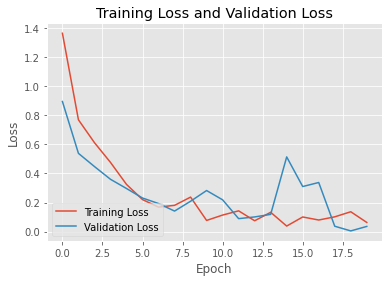

In [14]:
N = EPOCHS

plt.figure()
plt.plot(np.arange(0, N), HR.history["loss"], label="Training Loss")
plt.plot(np.arange(0, N), HR.history["val_loss"], label="Validation Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("LossPlotWMF.png")


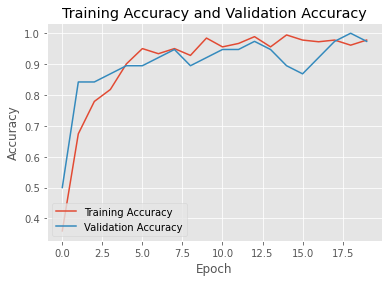

In [15]:
plt.figure()
plt.plot(np.arange(0, N), HR.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, N), HR.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training Accuracy and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("AccuracyPlotWMF.png")